## Setup

In [1]:
# Import statements

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
import xarray as xr
from metpy.calc import dewpoint_from_relative_humidity
from metpy.io import parse_wpc_surface_bulletin
from metpy.plots import (
    ColdFront,
    OccludedFront,
    StationaryFront,
    StationPlot,
    WarmFront,
)
from metpy.units import units

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True


In [3]:
ds = xr.open_dataset("data/era5_data.nc").squeeze()
ds_rh = xr.open_dataset("data/era5_rh_data.nc").squeeze()

proj = ccrs.LambertConformal(
    central_longitude=-90, central_latitude=35, standard_parallels=(30, 60)
)

# Define extent bounds
lon_min, lon_max = 255, 300
lat_min, lat_max = 23, 52

# Subset the dataset to the extent
ds_contours = ds.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max)).where(
    (ds.latitude >= lat_min) & (ds.latitude <= lat_max)
)

dx = 10
lat = ds.latitude[::dx]
lon = ds.longitude[::dx]
u = ds.u.squeeze()[:, ::dx, ::dx]
v = ds.v.squeeze()[:, ::dx, ::dx]
mag = (ds.u**2 + ds.v**2) ** 0.5 * 1.94384

# get absolute vorticity
omega = 7.2921e-5
f = 2 * omega * np.sin(np.deg2rad(ds.latitude))

abs_vort = ds.vo + f

td = dewpoint_from_relative_humidity(
    ds.t.sel(pressure_level=850.0).squeeze() * units.K,
    ds_rh.r.sel(pressure_level=850.0).squeeze() / 100 * units.dimensionless,
)


/tmp/ipykernel_3598220/281733275.py:30: UserWarning: Relative humidity >120%, ensure proper units.
  td = dewpoint_from_relative_humidity(
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/metpy/calc/thermo.py:1403: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


## Plotting

In [6]:
ds_sfc = xr.open_dataset("data/era5_surface_data.nc").squeeze()

# Subset the dataset to the extent
ds_sfc_contours = ds_sfc.where(
    (ds_sfc.longitude >= lon_min) & (ds_sfc.longitude <= lon_max)
).where((ds_sfc.latitude >= lat_min) & (ds_sfc.latitude <= lat_max))

dx = 10
lat = ds_sfc.latitude[::dx]
lon = ds_sfc.longitude[::dx]
u10 = ds_sfc.u10.squeeze()[::dx, ::dx]
v10 = ds_sfc.v10.squeeze()[::dx, ::dx]

df = parse_wpc_surface_bulletin("data/nws_coded_surface_bulletin_090225_hires.txt")


# Set MetPy styles
size = 2
fontsize = 6
complete_style = {
    "HIGH": {"color": "blue", "fontsize": fontsize},
    "LOW": {"color": "red", "fontsize": fontsize},
    "WARM": {"linewidth": 0.8, "path_effects": [WarmFront(size=size)]},
    "COLD": {"linewidth": 0.8, "path_effects": [ColdFront(size=size)]},
    "OCFNT": {"linewidth": 0.8, "path_effects": [OccludedFront(size=size)]},
    "STNRY": {"linewidth": 0.8, "path_effects": [StationaryFront(size=size)]},
    "TROF": {"linewidth": 0.8, "linestyle": "dashed", "edgecolor": "darkorange"},
}


### Combined Plot

/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cartopy/crs.py:546: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cartopy/crs.py:546: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cartopy/crs.py:546: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


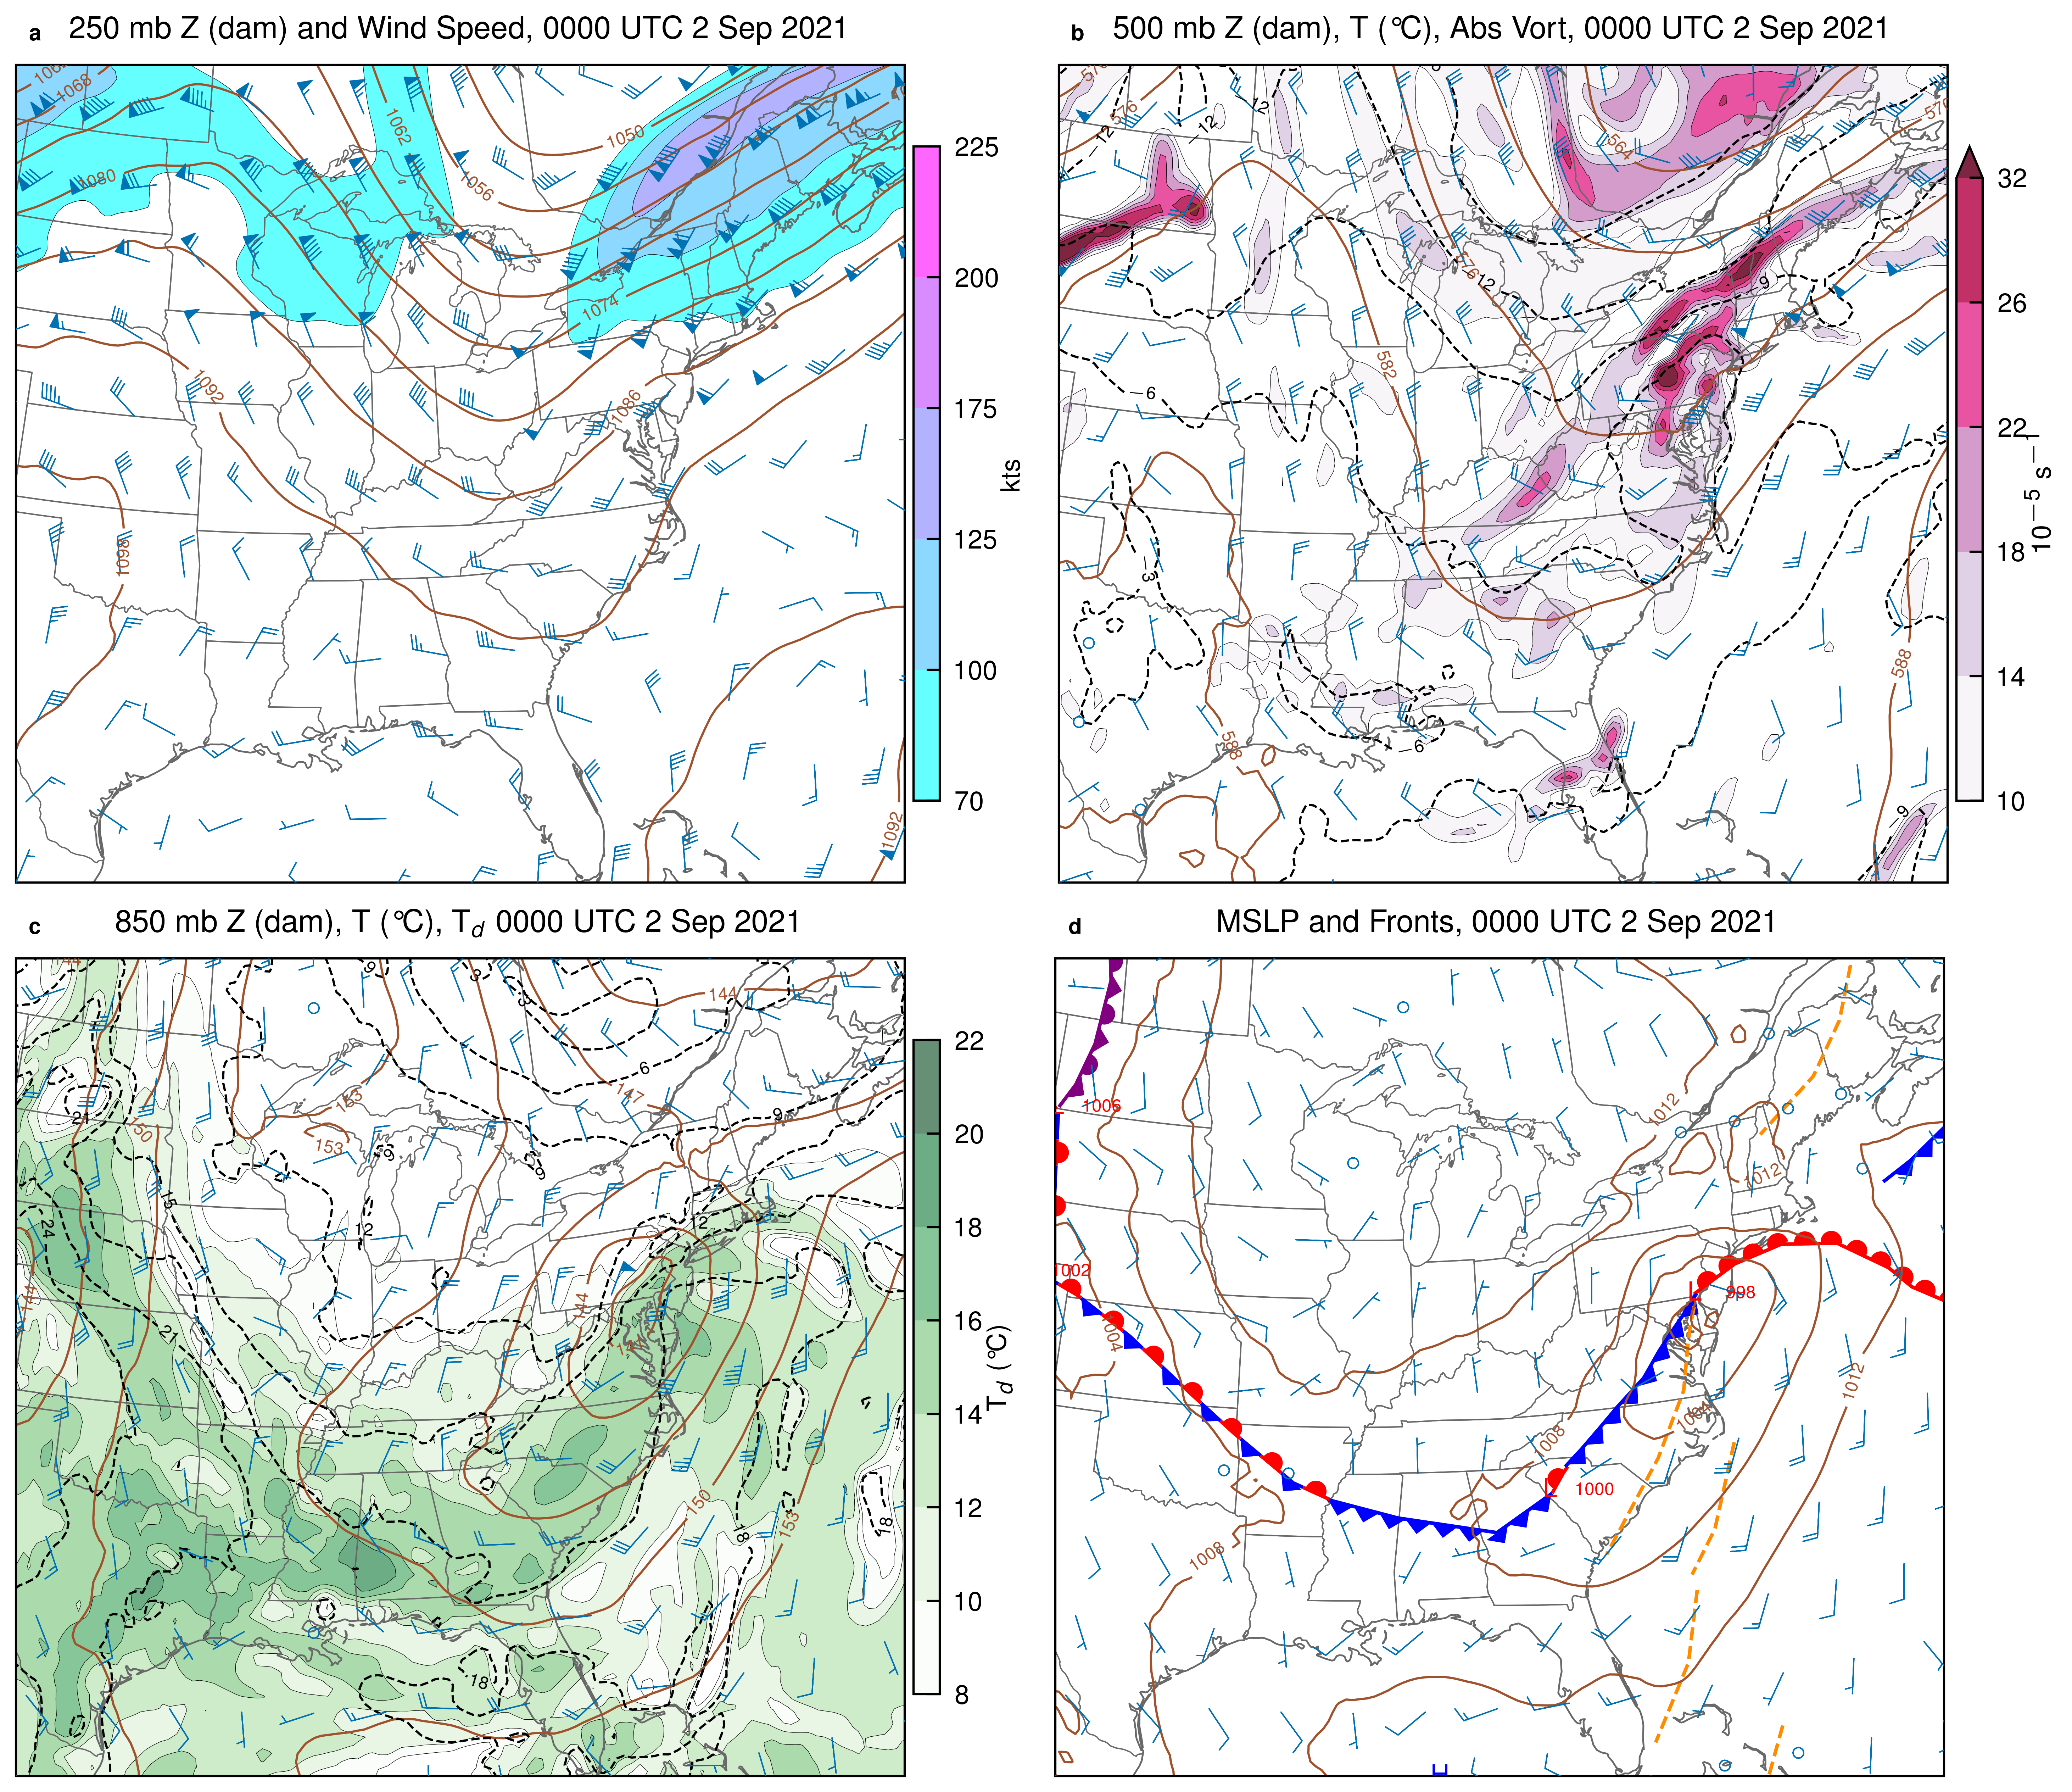

In [8]:
# Set the levels for contouring later
lev_250 = range(1044, 1128, 6)
lev_500 = range(552, 595, 6)
lev_850 = range(138, 160, 3)
lev_sfc = range(996, 1013, 4)

letters = ["a", "b", "c", "d"]

fill_levels = {
    250.0: [70, 100, 125, 175, 200, 225],
    500.0: [10, 14, 18, 22, 26, 32],
    850.0: range(8, 24, 2),
}

temp_levels_500 = range(-18, 1, 3)
temp_levels_850 = np.arange(-12, 25, 3)

# Create 2x2 figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    dpi=900,
    layout="constrained",
    subplot_kw=dict(projection=proj),
    figsize=(6.5, 5.6),
)

# Create list of plot parameters
plot_params = [
    (
        250.0,
        axes[0, 0],
        ds_contours.z,
        mag,
        "cool",
        lev_250,
        "250 mb Z (dam) and Wind Speed, 0000 UTC 2 Sep 2021",
        "kts",
    ),
    (
        500.0,
        axes[0, 1],
        ds_contours.z,
        abs_vort * 10**5,
        "PuRd",
        lev_500,
        "500 mb Z (dam), T (°C), Abs Vort, 0000 UTC 2 Sep 2021",
        "10$^{-5}$ s$^{-1}$",
    ),
    (
        850.0,
        axes[1, 0],
        ds_contours.z,
        td,
        "Greens",
        lev_850,
        "850 mb Z (dam), T (°C), T$_d$ 0000 UTC 2 Sep 2021",
        "T$_d$ (°C)",
    ),
    (
        "MSLP",
        axes[1, 1],
        ds_sfc_contours.msl,
        None,
        None,
        lev_sfc,
        "MSLP and Fronts, 0000 UTC 2 Sep 2021",
        None,
    ),
]

i=0
# Iterate through plot parameter list
for (
    level,
    ax,
    contour_data,
    fill_data,
    cmap,
    contour_levels,
    title,
    cbar_label,
) in plot_params:
    ax.set_extent([-100, -70, 25, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="dimgray")
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="dimgray")

    # Contour geopotential heights if not at surface
    if level != "MSLP":
        c = xr.plot.contour(
            contour_data.sel(pressure_level=level) / 98.10,
            colors="sienna",
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=contour_levels,
            linewidths=0.5,
            zorder=2,
        )
        ax.clabel(c, inline=True, fontsize=4)

        if level in [500.0, 850.0]:
            temp_levels = temp_levels_500 if level == 500.0 else temp_levels_850
            c_temp = xr.plot.contour(
                ds_contours.t.sel(pressure_level=level) - 273.15,
                colors="black",
                ax=ax,
                transform=ccrs.PlateCarree(),
                levels=temp_levels,
                linewidths=0.5,
                zorder=2,
                linestyles="dashed",
            )
            ax.clabel(c_temp, inline=True, fontsize=4)

        # Add wind barbs
        b = ax.barbs(
            lon,
            lat,
            u.sel(pressure_level=level).values * 1.94384,
            v.sel(pressure_level=level).values * 1.94384,
            transform=ccrs.PlateCarree(),
            length=4,
            linewidth=0.3,
            zorder=3,
            color="#0071b2",
        )

        # Contour fill whatever variable we care about at each level
        cf = xr.plot.contourf(
            fill_data.sel(pressure_level=level) if level != 850.0 else fill_data,
            cmap=cmap,
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=fill_levels[level],
            zorder=1,
            extend="neither" if level != 500.0 else "max",
            add_colorbar=False,
            alpha=0.85 if level == 500.0 else 0.6,
        )
        # Add a thin black line around our contour fill areas
        c1 = xr.plot.contour(
            fill_data.sel(pressure_level=level) if level != 850.0 else fill_data,
            colors="black",
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=fill_levels[level],
            zorder=1,
            linewidths=0.1,
        )
        # Add colorbar
        cb = fig.colorbar(
            cf, ax=ax, orientation="vertical", shrink=0.8, aspect=25, pad=0.01
        )
        cb.ax.tick_params(labelsize=6)
        cb.set_label(cbar_label, fontsize=6, labelpad=0.3)

    else:  # If we are at the surface
        c = xr.plot.contour(
            contour_data / 100,
            colors="sienna",
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=contour_levels,
            linewidths=0.5,
            zorder=2,
        )
        ax.clabel(c, inline=True, fontsize=4)

        b = ax.barbs(
            lon,
            lat,
            u10.values * 1.94384,
            v10.values * 1.94384,
            transform=ccrs.PlateCarree(),
            length=4,
            linewidth=0.3,
            zorder=3,
            color="#0071b2",
        )

        for field in ["WARM", "COLD", "STNRY", "OCFNT", "TROF"]:
            ax.add_geometries(
                df[df.feature == field].geometry,
                crs=ccrs.PlateCarree(),
                **complete_style[field],
                facecolor="None",
            )

        for field in ("HIGH", "LOW"):
            rows = df[df.feature == field]
            x, y = zip(*((pt.x, pt.y) for pt in rows.geometry))
            sp = StationPlot(ax, x, y, transform=ccrs.PlateCarree(), clip_on=True)
            color = "blue" if field == "HIGH" else "red"
            sp.plot_text(
                "C", [field[0]] * len(x), color=color, fontsize=6, fontweight="bold"
            )
            param = "S" if field == "HIGH" else "E"
            sp.plot_parameter(param, rows.strength, color=color, fontsize=4)

    ax.set_title(title, fontsize=7)
    ax.text(
        0.015, 1.03, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=5
    )
    i+=1

plt.savefig("figures/Fig3_era5_fields.pdf", bbox_inches="tight")